#  Домашнее задание 2
Кравцов Евгений, РИ-411001

Содержание:


# Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.ensemble import RandomForestRegressor

#Чтение Данные

In [ ]:
df = pd.read_csv("machine_temperature_system_failure.csv", index_col=['timestamp'], parse_dates=['timestamp'])
df.head()

,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22695 entries, 2013-12-02 21:15:00 to 2014-02-19 15:25:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   22695 non-null  float64
dtypes: float64(1)
memory usage: 354.6 KB


In [ ]:
df.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


Визуализируйте ряд и на основе его внешнего вида сделайте предположения о его компонентах:

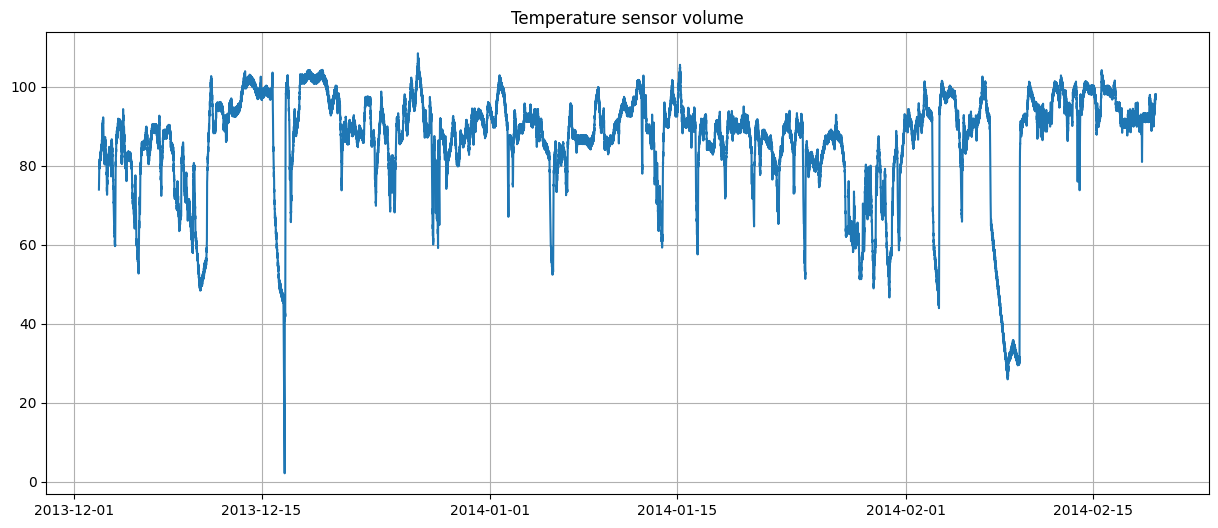

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df.value)
plt.title('Temperature sensor volume')
plt.grid(True)
plt.show()

Сезонности нет, тренда не наблюдается, стационарность есть.

Сделайте train/test split:

In [ ]:
def train_test_split(df, test_size):

    test_index = int(len(df)*(1-test_size))

    df_train = df.iloc[:test_index]
    df_test = df.iloc[test_index:]

    return df_train, df_test

df_train, df_test = train_test_split(df, test_size=0.3)

Выбреите релевантную, на ваш взгляд, метрику для последующих замеров качества:

В качестве метрики замера качества выбор пал на `MAE` - эта метрика измеряет среднее абсолютное отклонение каждого прогноза от фактического значения.

# Прогнозирование

## Бейзлайн

Постройте бейзлайн в виде наивного прогноза или `скользящего среднего`:




In [ ]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(df_train, 288) # Окно размером в 1 день

87.45328289416666

Визуализируйте результаты работы модели, произведите замеры качества с выбранной метрикой:

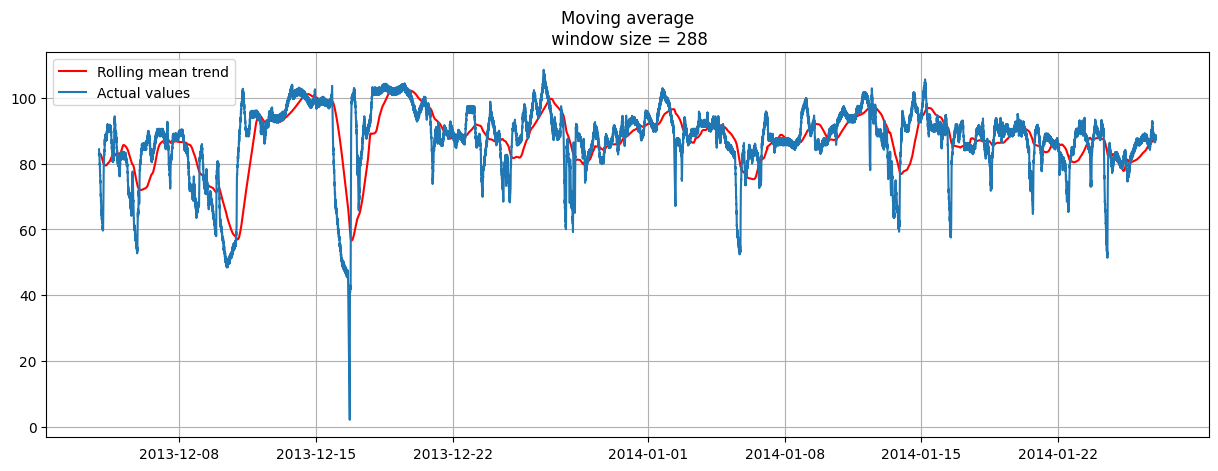

In [ ]:
def plotMovingAverage(series, window):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

plotMovingAverage(df_train, 288) # Окно размером в 1 день

In [ ]:
mean_absolute_error([moving_average(df_train, 288)], df_test.head(1))

1.0290467258333393

После валидации выявлено отклонение температуры от фактического значения на ~ 1 градус

## Статистическая модель

Проведите тест Дики-Фуллера и интерпретируйте результаты:

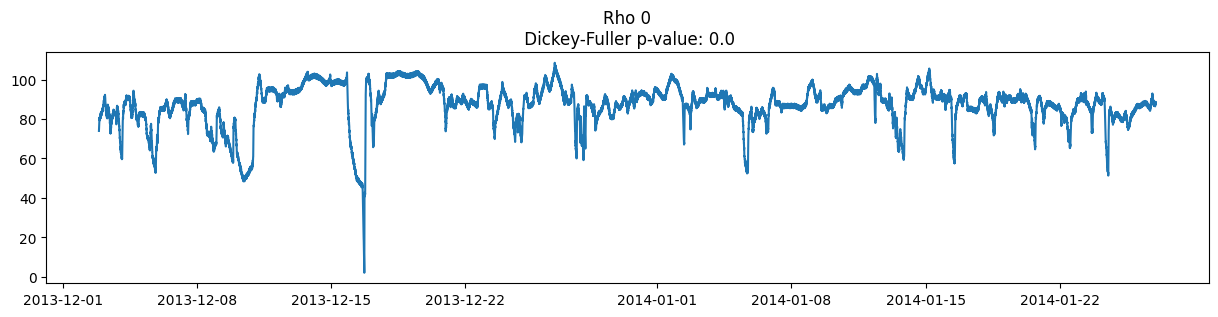

In [ ]:
plt.style.context('bmh')
plt.figure(figsize=(15, 3))
plt.plot(df_train)
plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(df_train)[1], 3)))
plt.show()

Постройте графики ACF/PACF и проанализируйте их, сделайте предположения о наличии/отсутствии сезонности:

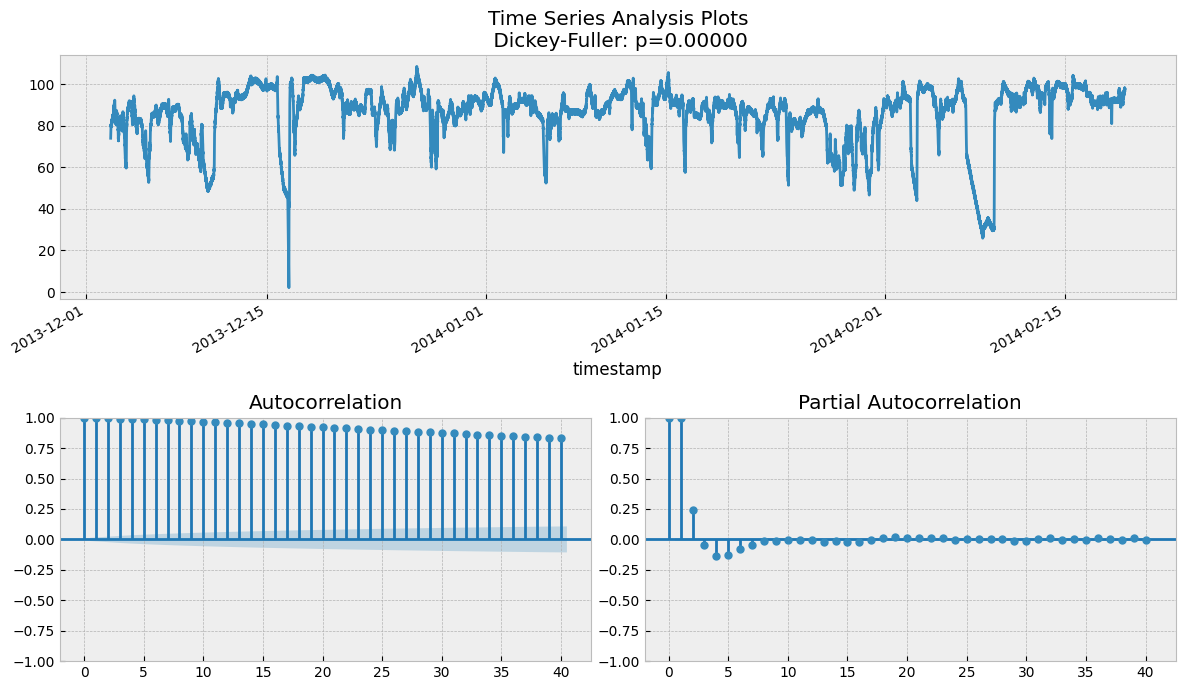

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(df.value, lags=40)

## Классическая модель

Используйте Feature-Engineering для создания признаков (лаги, скользящие статистики, признаки даты/времени, etc):

Добавим 3 признака: часы, дни, месяца

In [ ]:
data = pd.DataFrame(df.value.copy())
data.columns = ["y"]
data["hour"] = data.index.hour
data['day'] = data.index.day
data['month'] = data.index.month

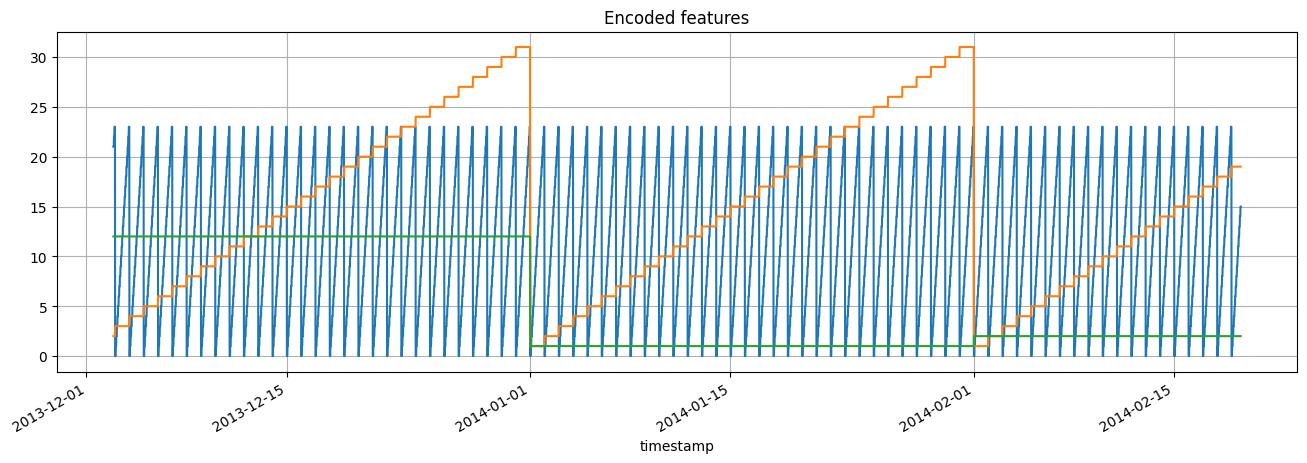

In [ ]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.day.plot()
data.month.plot()
plt.grid(True)

На полученном наборе данных обучите `случайный лес` или градиентный бустинг:

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def train_test_split(X, y, test_size):

    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
regr = RandomForestRegressor(max_depth=6, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, random_state=42)

Визуализируйте результаты работы модели, произведите замеры качества модели:

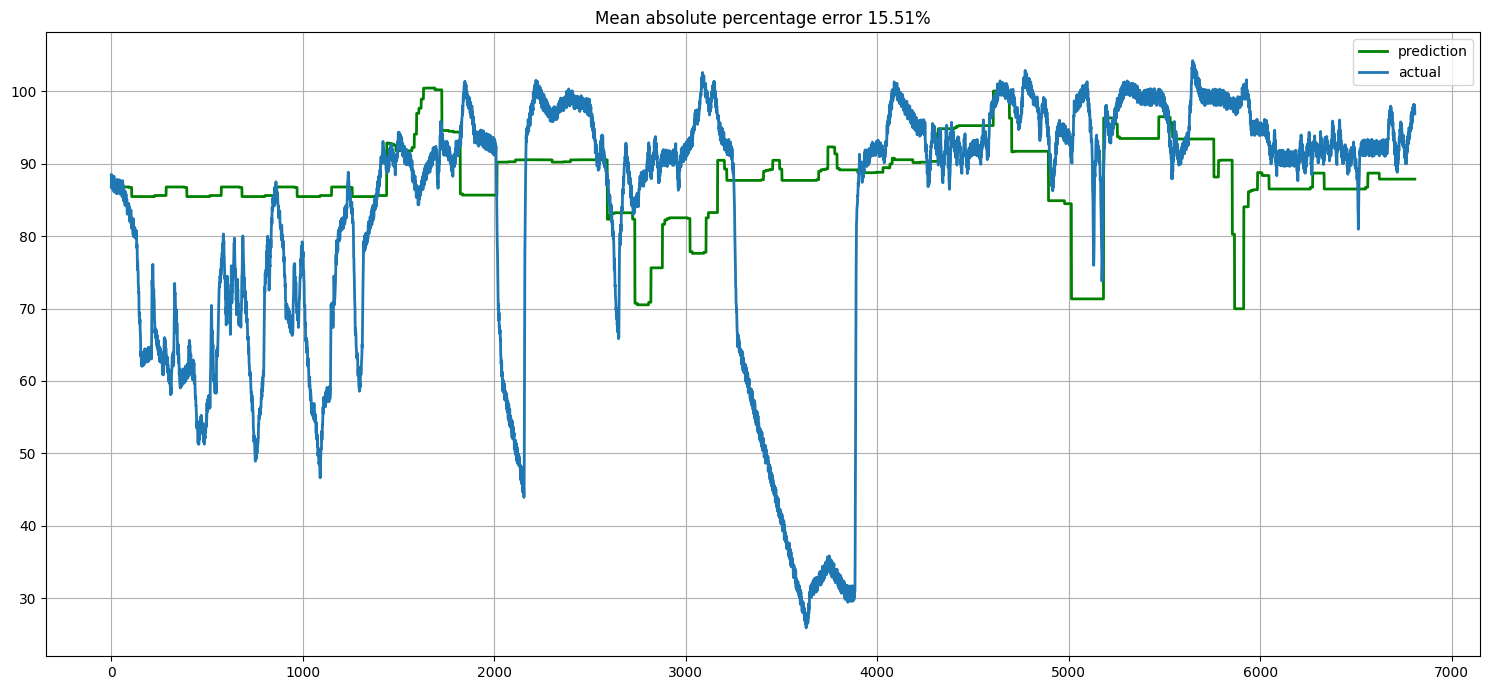

In [ ]:
def plotModelResults(model, X_train=X_train, X_test=X_test):

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

plotModelResults(regr, X_train=X_train, X_test=X_test)

Абсолютная ошибка составила 15.51%. Потому что было добавлено мало признаков.